In [1]:
import sys
sys.path.append('/home/wangs/rs/lib') 
import ff
import extend

import tushare as ts
pro = ts.pro_api('5b6a2c5b17b9572fe089a0802765f8b6434e72c51572718b1d37c302')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
from sklearn.linear_model import LinearRegression
import scipy.stats as st

import matplotlib as mpl
mpl.rc("font",family='Droid Sans Fallback',weight="bold")

from multiprocessing import Pool
from tqdm import tqdm

import pickle

In [76]:
# 定义时间区间的端点
start, end = '20200101', '20230414'

# 处理数据
def my_dropna(df):
    return df.dropna(how='all').dropna(how='all', axis=1)

# 获得每日数据
def read_data(keyword, start=start, end=end):
    data_keyword = ff.read(keyword).astype('float')
    if keyword in ['open', 'close', 'high', 'low']:
        data_keyword = data_keyword * ff.read('post')
    data_keyword = (data_keyword * ff.filter0).loc[:, start:end]
    return data_keyword

# 获得分钟数据
def get_min_data(stock):  
    global start, end
    current_data = ff.read_min(stock)
    current_data.index = pd.to_datetime(current_data.index)
    current_data = current_data[start:end]
    current_data['average'] = current_data['money'] / current_data['volume']
    current_data['tradedate'] = current_data.index.strftime('%Y%m%d')
    return current_data

stock_names = list(my_dropna(ff.filter0).index)
trade_dates = list(get_min_data(stock_names[0]).tradedate.unique())

In [77]:
stock_names.index('000410.SZ')

77

In [3]:
CLOSE, OPEN, TURNOVER = read_data('close'), read_data("open"), read_data("turnover_rate")
FLOAT_SHARE = read_data("float_share")
intraday_ret = (CLOSE - OPEN) / OPEN
overnight_ret = (OPEN.shift(-1, axis=1) - CLOSE) / CLOSE

In [8]:
'''def get_intraday_turnover_single(stock):
    global FLOAT_SHARE
    tmp = get_min_data(stock).groupby("tradedate").apply(lambda df: df.volume.iloc[1:].sum() / FLOAT_SHARE.loc[stock, df.tradedate.iloc[0]] / 100)
    if tmp.shape[0]:
        return pd.Series(tmp, name=stock)
    else:
        return pd.Series(name=stock)

with Pool(24) as p:
    TURNOVER = pd.concat(list(tqdm(p.imap(get_intraday_turnover_single, stock_names), total=len(stock_names))), axis=1).T'''

def get_overnight_turnover_single(stock):
    global FLOAT_SHARE
    tmp = get_min_data(stock).groupby("tradedate").apply(lambda df: df.volume.iloc[0] / FLOAT_SHARE.loc[stock, df.tradedate.iloc[0]] / 100).shift(-1)
    if tmp.shape[0]:
        return pd.Series(tmp, name=stock)
    else:
        return pd.Series(name=stock)
        
with Pool(24) as p:
    overnight_turnover = pd.concat(list(tqdm(p.imap(get_overnight_turnover_single, stock_names), total=len(stock_names))), axis=1).T


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [02:50<00:00, 29.49it/s]


In [11]:
overnight_turnover.head()

,20200102,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,NaN,0.020811,0.014468,0.006741,0.007016,0.017828,0.009335,0.005724,0.033567,0.009980,...,0.011207,0.011826,0.012208,0.006102,0.006776,0.012073,0.013922,0.006639,0.016023,0.014974
000002.SZ,NaN,0.022987,0.019330,0.010327,0.028795,0.036813,0.008594,0.018964,0.011002,0.006870,...,0.017325,0.019438,0.017280,0.016784,0.043841,0.081988,0.034562,0.045636,0.032780,0.025803
000004.SZ,NaN,0.020217,0.010048,0.027117,0.012711,0.027843,0.016585,0.077720,0.058350,0.036439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,0.019784,0.014235,0.010426,0.027752,0.027109,0.035928,0.012817,0.019311,0.005246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,0.017815,0.020989,0.011728,0.021049,0.017911,0.015086,0.005196,0.012138,0.003271,...,0.013495,0.012637,0.012904,0.009407,0.026215,0.067363,0.023096,0.044215,0.010978,0.008978


In [10]:
overnight_turnover=overnight_turnover.shift(1,axis=1)

In [12]:
TURNOVER=TURNOVER-overnight_turnover

In [13]:
TURNOVER.head()

,20200102,20200103,20200106,20200107,20200108,20200109,20200110,20200113,20200114,20200115,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,NaN,0.554389,0.429732,0.368759,0.429884,0.513772,0.292365,0.443676,0.638633,0.432920,...,0.434793,0.369774,0.321392,0.284198,0.306524,0.317827,0.386878,0.462261,0.567077,0.653926
000002.SZ,NaN,0.806213,0.883170,0.584573,0.516705,0.769887,0.565206,0.619936,0.420998,0.685830,...,1.371775,1.182062,1.223320,0.799716,2.266159,1.025512,1.746438,1.031164,0.841120,0.667197
000004.SZ,NaN,1.599583,2.449452,2.083283,1.864189,1.475157,2.068915,4.174680,2.300850,1.724161,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,0.753316,0.859065,1.395274,2.162648,1.464991,1.087972,0.642683,1.381489,0.797454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,1.210785,0.773611,0.635572,0.774051,0.582289,0.983514,0.845904,0.736562,0.659029,...,0.910505,1.406863,1.454596,1.021193,2.511185,1.644837,1.882604,1.331785,1.126822,1.273322


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [00:51<00:00, 96.97it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0
交易模式： t日收盘价买入，收盘价卖出


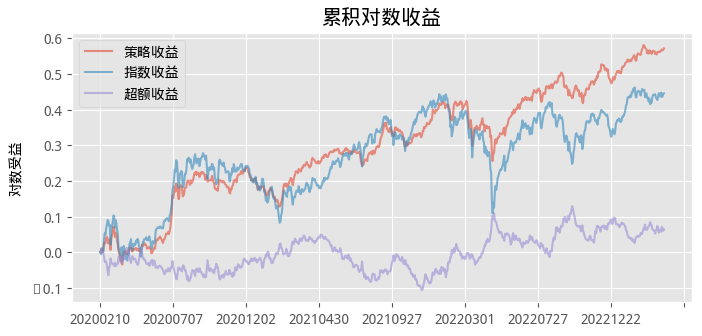

,指数收益,超额收益,策略收益
年化收益率,0.144,0.021,0.185
年化波动率,0.211,0.126,0.141
夏普率,0.684,0.164,1.315
最大回撤,-0.335,-0.156,-0.169
收益回撤比,0.430,0.132,1.094
胜率,0.541,0.477,0.541
盈亏比,0.949,1.124,1.069


In [14]:
def overnight_ret_intraday_turnover_calculator(df):
    return df.sort_values('overnight_ret')[:4].turnover.mean()

def overnight_ret_intraday_turnover(stock):
    global overnight_ret, TURNOVER
    ret_single, turnover_single = overnight_ret.loc[stock], TURNOVER.loc[stock]
    total_data = ret_single.to_frame(name='overnight_ret').assign(turnover=turnover_single)
    return ret_single.rolling(20).apply(lambda x: overnight_ret_intraday_turnover_calculator(total_data.loc[x.index]))

with Pool(24) as p:
    ORIT_list = list(tqdm(p.imap(overnight_ret_intraday_turnover, stock_names), total=len(stock_names)))

ORIT = pd.DataFrame(ORIT_list).dropna(how='all', axis=1)


In [20]:
ORIT.shift(1, axis=1).head()

,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,...,20230330,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413
000001.SZ,NaN,0.517029,0.517029,0.470622,0.470622,0.492273,0.492273,0.492273,0.492273,0.492273,...,0.567384,0.567384,0.567384,0.567384,0.567384,0.567384,0.432620,0.432620,0.408714,0.424068
000002.SZ,NaN,0.846335,0.846335,0.846335,0.846335,0.931640,0.931640,0.931640,0.956400,0.956400,...,0.635085,0.635085,0.635085,0.635085,0.635085,0.635085,1.065002,1.111984,1.111984,1.203254
000004.SZ,NaN,2.127366,2.127366,2.127366,2.127366,2.286291,2.286291,2.286291,2.286291,2.286291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,0.663422,0.854655,0.854655,0.854655,0.854655,0.854655,0.854655,0.854655,0.854655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,0.741776,0.646659,0.646659,0.646659,0.646659,0.646659,0.646659,0.646659,0.646659,...,3.098831,3.098831,2.421628,2.421628,2.421628,2.421628,2.370825,1.870474,1.650310,1.650310


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0
交易模式： t日收盘价买入，收盘价卖出


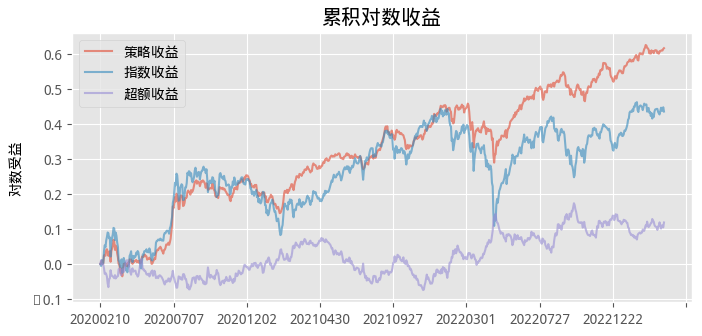

,指数收益,超额收益,策略收益
年化收益率,0.141,0.038,0.200
年化波动率,0.211,0.126,0.140
夏普率,0.669,0.306,1.428
最大回撤,-0.335,-0.149,-0.169
收益回撤比,0.422,0.259,1.186
胜率,0.541,0.481,0.547
盈亏比,0.949,1.130,1.064


In [21]:
ff.run((ORIT.shift(1, axis=1) * ff.filter0).loc[:,'20200210':'20230410'], positions=100, period=1, fees=0.0);

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [00:52<00:00, 95.43it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0
交易模式： t日收盘价买入，收盘价卖出


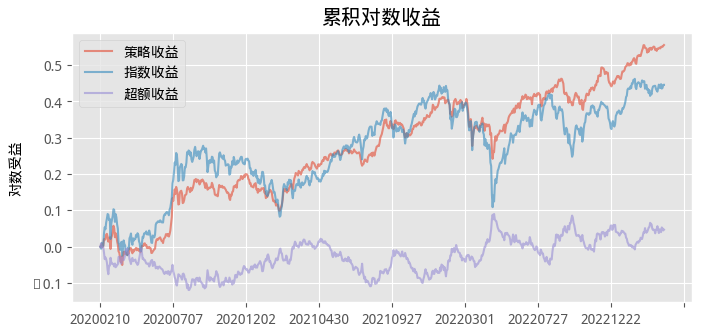

,指数收益,超额收益,策略收益
年化收益率,0.144,0.015,0.179
年化波动率,0.211,0.127,0.141
夏普率,0.684,0.119,1.276
最大回撤,-0.335,-0.140,-0.170
收益回撤比,0.430,0.109,1.055
胜率,0.541,0.470,0.554
盈亏比,0.949,1.146,1.007


In [48]:
def overnight_turnover_intraday_turnover_calculator(df):
    return df.sort_values('overnight_turnover')[:4].turnover.mean()

def overnight_turnover_intraday_turnover(stock):
    global overnight_turnover, TURNOVER
    overnight_turnover_single, turnover_single = overnight_turnover.loc[stock], TURNOVER.loc[stock]
    total_data = overnight_turnover_single.to_frame(name='overnight_turnover').assign(turnover=turnover_single)
    return overnight_turnover_single.rolling(20).apply(lambda x: overnight_turnover_intraday_turnover_calculator(total_data.loc[x.index]))

with Pool(24) as p:
    OTIT_list = list(tqdm(p.imap(overnight_turnover_intraday_turnover, stock_names), total=len(stock_names)))

OTIT = pd.DataFrame(OTIT_list).dropna(how='all', axis=1)
ff.run((OTIT.shift(2, axis=1) * ff.filter0).loc[:, start:end], positions=100, period=1, fees=0.0);

In [60]:
OTIT.head()

,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,...,20230330,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413
000001.SZ,0.437813,0.437813,0.437813,0.453103,0.475903,0.475903,0.475903,0.478239,0.478239,0.522104,...,0.501138,0.501138,0.446539,0.408887,0.379492,0.379492,0.379492,0.367364,0.367364,0.367364
000002.SZ,0.564141,0.564141,0.633048,0.592165,0.592165,0.592165,0.555453,0.555453,0.603749,0.550719,...,0.654684,0.654684,0.624193,0.624193,0.624193,0.624193,0.624193,0.654011,0.697982,0.697982
000004.SZ,1.909827,1.909827,1.687580,1.700601,1.624690,1.662764,1.535669,1.535669,1.535669,1.535669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,0.869802,0.869802,0.869802,0.676285,0.676285,0.689098,0.689098,0.689098,0.689098,0.759439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,0.614432,0.614432,0.614432,0.614432,0.614432,0.637070,0.637070,0.573632,0.651911,0.635190,...,1.444538,1.471511,1.517196,1.198278,1.198278,1.198278,1.198278,1.198278,1.252360,1.207046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [01:09<00:00, 71.79it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0
交易模式： t日收盘价买入，收盘价卖出


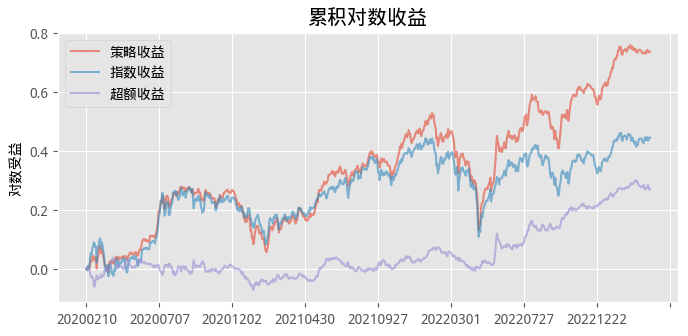

,指数收益,超额收益,策略收益
年化收益率,0.144,0.087,0.238
年化波动率,0.211,0.093,0.198
夏普率,0.684,0.936,1.203
最大回撤,-0.335,-0.109,-0.397
收益回撤比,0.430,0.801,0.600
胜率,0.541,0.510,0.561
盈亏比,0.949,1.122,0.963


In [22]:
def overnight_smart_calculator(df):
    overnight_smart = (df.overnight_ret - df.overnight_ret.min()) / (df.overnight_ret.max() - df.overnight_ret.min()) / df.overnight_turnover
    return overnight_smart.mean()

def overnightsmart20(stock):
    global overnight_ret, overnight_turnover
    overnight_ret_single, overnight_turnover_single = overnight_ret.loc[stock], overnight_turnover.loc[stock]
    total_data = overnight_ret_single.to_frame(name='overnight_ret').assign(overnight_turnover=overnight_turnover_single)
    return overnight_ret_single.rolling(20).apply(lambda x: overnight_smart_calculator(total_data.loc[x.index]))

with Pool(24) as p:
    overnightsmart20_list = list(tqdm(p.imap(overnightsmart20, stock_names), total=len(stock_names)))

OS20 = pd.DataFrame(overnightsmart20_list).dropna(how='all', axis=1)
ff.run((-OS20.shift(2, axis=1) * ff.filter0).loc[:, start:end], positions=100, period=1, fees=0.0);

In [26]:
OS20.head()

,20200206,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,...,20230330,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413
000001.SZ,75.024265,73.210778,75.735757,74.590567,72.005750,70.081757,69.324100,66.391071,62.425244,66.043406,...,36.592891,36.859688,35.974207,34.487369,37.105402,37.604079,39.216721,40.567665,41.612952,32.651845
000002.SZ,47.266907,47.293058,48.508638,50.977103,51.687512,51.734403,52.498845,48.877324,47.926572,47.583770,...,27.722837,28.418721,28.205221,27.337853,21.372945,15.249464,18.491590,18.242983,18.328078,18.587915
000004.SZ,29.675076,29.641806,28.760786,25.428411,27.991720,25.413940,24.515902,18.601837,18.270190,17.763519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,67.423566,67.147727,66.514364,65.332809,69.466204,73.824689,79.060825,84.313088,82.503989,84.275326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,83.516176,81.393220,81.577395,84.183640,83.446075,82.945668,86.842690,85.480375,79.118250,81.938053,...,16.806869,19.267210,21.825396,23.976850,26.163527,26.859629,18.194238,19.637496,19.777840,23.136871


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [00:52<00:00, 96.47it/s]


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0
交易模式： t日收盘价买入，收盘价卖出


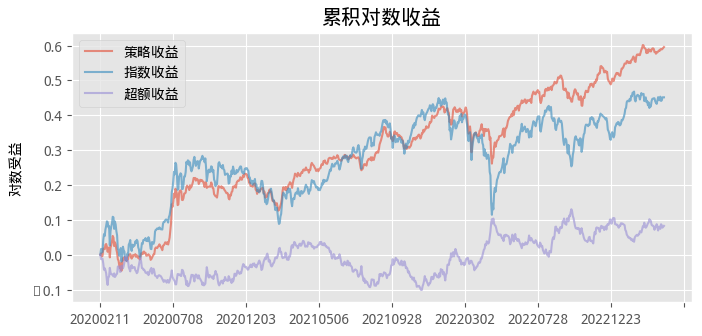

,指数收益,超额收益,策略收益
年化收益率,0.146,0.027,0.192
年化波动率,0.211,0.126,0.142
夏普率,0.693,0.211,1.356
最大回撤,-0.335,-0.141,-0.164
收益回撤比,0.436,0.189,1.171
胜率,0.541,0.473,0.549
盈亏比,0.951,1.151,1.045


In [27]:
def overnight_smartmoney_intraday_turnover_calculator(df):
    return df.sort_values('smartmoney')[:4].turnover.mean()

def overnight_smartmoney_intraday_turnover(stock):
    global OS20, TURNOVER
    turnover_single, smartmoney_single = TURNOVER.loc[stock], OS20.loc[stock]
    total_data = turnover_single.to_frame(name='turnover').assign(smartmoney=smartmoney_single)
    return turnover_single.rolling(20).apply(lambda x: overnight_smartmoney_intraday_turnover_calculator(total_data.loc[x.index]))

with Pool(24) as p:
    OSIT_list = list(tqdm(p.imap(overnight_smartmoney_intraday_turnover, stock_names), total=len(stock_names)))

OSIT = pd.DataFrame(OSIT_list).dropna(how='all', axis=1)
ff.run((OSIT.shift(2, axis=1) * ff.filter0).loc[:, start:end], positions=100, period=1, fees=0.0);

In [28]:
OSIT.head()

,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,20200220,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,0.507806,0.539111,0.607547,0.572441,0.552650,0.565189,0.644823,0.632724,0.614897,0.583603,...,0.366716,0.386514,0.358163,0.358163,0.358163,0.358163,0.358163,0.358163,0.418683,0.418683
000002.SZ,0.817484,0.846874,0.800231,0.800231,0.800231,0.800231,0.882290,0.819630,0.742227,0.750193,...,0.575387,0.575387,0.724334,0.618433,1.058031,1.186862,1.459456,1.517318,1.517318,1.517318
000004.SZ,2.451810,2.701192,2.606124,2.329537,1.958513,1.737443,2.163786,3.409562,3.562345,7.361455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,1.001767,1.124632,1.123870,1.123870,1.123870,1.123870,1.123870,1.123870,1.123870,1.123870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,0.871706,0.747346,0.813630,0.708354,0.709435,0.709435,0.709435,0.739669,0.796856,0.766021,...,2.195995,2.390697,2.250158,2.369973,2.319170,1.615697,1.440902,1.365357,1.333959,1.316917


In [29]:
import extend
mkv = read_data("total_mv")

def CTR_calculator(df):
    df['overnight_smartmoney'] = (df.overnight_ret - df.overnight_ret.min()) / (df.overnight_ret.max() - df.overnight_ret.min()) / df.overnight_turnover
    selected_index = df.iloc[1:].sort_values("overnight_smartmoney")[:4].index
    return df.shift(1).loc[selected_index].turnover.mean()

def get_CTR(stock):
    global overnight_turnover, overnight_ret, TURNOVER
    overnight_turnover_single, overnight_ret_single = overnight_turnover.loc[stock], overnight_ret.loc[stock]
    turnover_single = TURNOVER.loc[stock]
    total_data = overnight_turnover_single.to_frame(name='overnight_turnover').assign(overnight_ret=overnight_ret_single, turnover=turnover_single)
    return overnight_turnover_single.rolling(20+1).apply(lambda x: CTR_calculator(total_data.loc[x.index]))

with Pool(24) as p:
    CTR_list = list(tqdm(p.imap(get_CTR, stock_names), total=len(stock_names)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5025/5025 [03:15<00:00, 25.65it/s]


In [82]:
CTR = pd.DataFrame(CTR_list).shift(1,axis=1).dropna(how='all',axis=0)

In [92]:
CTR.loc['000001.SZ',]

20200102         NaN
20200103         NaN
20200106         NaN
20200107         NaN
20200108         NaN
              ...   
20230410    0.564376
20230411    0.462802
20230412    0.469600
20230413    0.469600
20230414    0.420226
Name: 000001.SZ, Length: 796, dtype: float64

In [81]:
len(stock_names)

5025

In [41]:
CTR_neutralized = extend.spread_reg(CTR, mkv.loc[CTR.index,CTR.columns], ind=False)

In [42]:
CTR_neutralized.head()

,20200211,20200212,20200213,20200214,20200217,20200218,20200219,20200220,20200221,20200224,...,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413,20230414
000001.SZ,-1.469061,-1.497294,-1.500473,-1.478179,-1.452535,-1.477294,-1.488306,-1.582369,-1.604147,-1.666936,...,-1.685287,-1.683052,-1.705373,-1.758904,-1.758661,-1.810642,-1.930521,-1.980916,-1.981887,-2.049799
000002.SZ,-0.879293,-0.906758,-0.861636,-0.830269,-0.851846,-0.897174,-0.911504,-1.043231,-1.087378,-1.139113,...,-1.687893,-1.912014,-1.934026,-1.983660,-1.948149,-1.981102,-1.537022,-1.579750,-1.278418,-1.308931
000004.SZ,-1.226838,-1.248770,-1.257369,-1.266080,-1.227291,-1.218897,-0.727202,0.105004,0.075379,4.175194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,-2.541355,-2.563360,-2.572020,-2.580802,-2.542849,-2.535804,-2.561147,-2.663840,-2.695344,-2.742346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,-2.433511,-2.455599,-2.463907,-2.582459,-2.544727,-2.538061,-2.563007,-2.666047,-2.697418,-2.744584,...,-0.244855,-0.295546,-1.089951,-1.123997,-1.130462,-1.170145,-0.882897,-1.870755,-2.110930,-1.954937


In [ ]:
CTR = pd.DataFrame(CTR_list).dropna(how='all', axis=1)
CTR_neutralized = extend.spread_reg(CTR, mkv, ind=False)
ff.run((CTR_neutralized.shift(2, axis=1) * ff.filter0).loc[:, start:end], positions=100, period=1, fees=0.0);

In [62]:
CTR.head()

,20200207,20200210,20200211,20200212,20200213,20200214,20200217,20200218,20200219,20200220,...,20230330,20230331,20230403,20230404,20230406,20230407,20230410,20230411,20230412,20230413
000001.SZ,0.668301,0.668301,0.668301,0.668301,0.648523,0.648523,0.648523,0.685525,0.685525,0.685525,...,0.595668,0.595668,0.595668,0.595668,0.567389,0.453718,0.452477,0.521920,0.443917,0.517577
000002.SZ,0.953079,0.953079,0.953079,0.936126,0.911528,0.911528,1.063151,1.063151,1.063151,1.063151,...,0.635091,0.635091,0.635091,0.635091,0.635091,1.065024,1.154868,1.154868,1.290106,1.290106
000004.SZ,1.920729,1.920729,1.920729,1.920729,1.920729,1.588004,2.103323,3.438189,3.150241,6.836005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000005.SZ,0.608139,0.608139,0.608139,0.608139,0.608139,0.608139,0.608139,0.608139,0.608139,0.608139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,0.868910,0.725101,0.725101,0.720632,0.720632,0.720632,0.720632,0.720632,0.720632,0.720632,...,3.031853,2.468763,2.468763,2.468763,2.468763,2.468763,2.058098,1.650322,1.650322,1.980096


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0.0
交易模式： t日收盘价买入，收盘价卖出


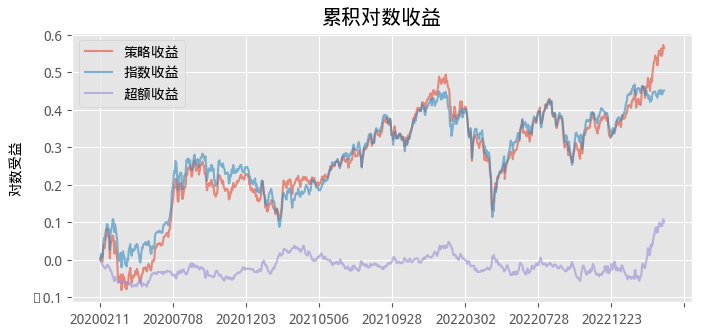

,指数收益,超额收益,策略收益
年化收益率,0.146,0.032,0.183
年化波动率,0.211,0.089,0.209
夏普率,0.693,0.363,0.873
最大回撤,-0.335,-0.105,-0.361
收益回撤比,0.436,0.308,0.506
胜率,0.542,0.485,0.543
盈亏比,0.948,1.125,0.970


In [54]:
CTR_pure = extend.spread_reg(CTR, mkv, ind=True)
ff.run((CTR_pure.shift(2, axis=1) * ff.filter0).loc[:, start:end], positions=100, period=1, fees=0.0);